In [1]:
import torch
from torchinfo import summary

from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchvision import transforms
from predict import predict
from train import train, test
from utils import get_transform, centre_transform, centre_of_mass

In [2]:
PATCH_SIZE = 8 # P
IMAGE_CROP = 240
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
DATA_SPLIT = 0.8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device: cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [3]:
train_transform = get_transform(data_type="train",
                                    data_mean=0.1155,
                                    data_std=0.2224,
                                    image_size=IMAGE_WIDTH)

valid_transform = get_transform(data_type="valid",
                                    data_mean=0.1155,
                                    data_std=0.2224,
                                    image_size=IMAGE_WIDTH)

test_transform = get_transform(data_type="test",
                                    data_mean=0.1167,
                                    data_std=0.2228,
                                    image_size=IMAGE_WIDTH)

from dataset import create_dataloaders
root_dir = "C:/Users/Jacqu/Downloads/AD_NC"
train_loader, valid_loader, test_loader = create_dataloaders(root_dir, 
                                                            train_transform,
                                                            valid_transform,
                                                            test_transform,
                                                            batch_size=BATCH_SIZE,
                                                            datasplit=DATA_SPLIT)

print(f"Num images for train: {len(train_loader.dataset)}")
print(f"Num images for valid: {len(valid_loader.dataset)}")
print(f"Num images for test: {len(test_loader.dataset)}")

Num images for train: 17200
Num images for valid: 4320
Num images for test: 9000


c:\Users\Jacqu\miniconda3\envs\conda-torch\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\Jacqu\miniconda3\envs\conda-torch\Lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Users\Jacqu\miniconda3\envs\conda-torch\Lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for detai

x_trans: 12.758987426757812, y_trans: -15.894157409667969


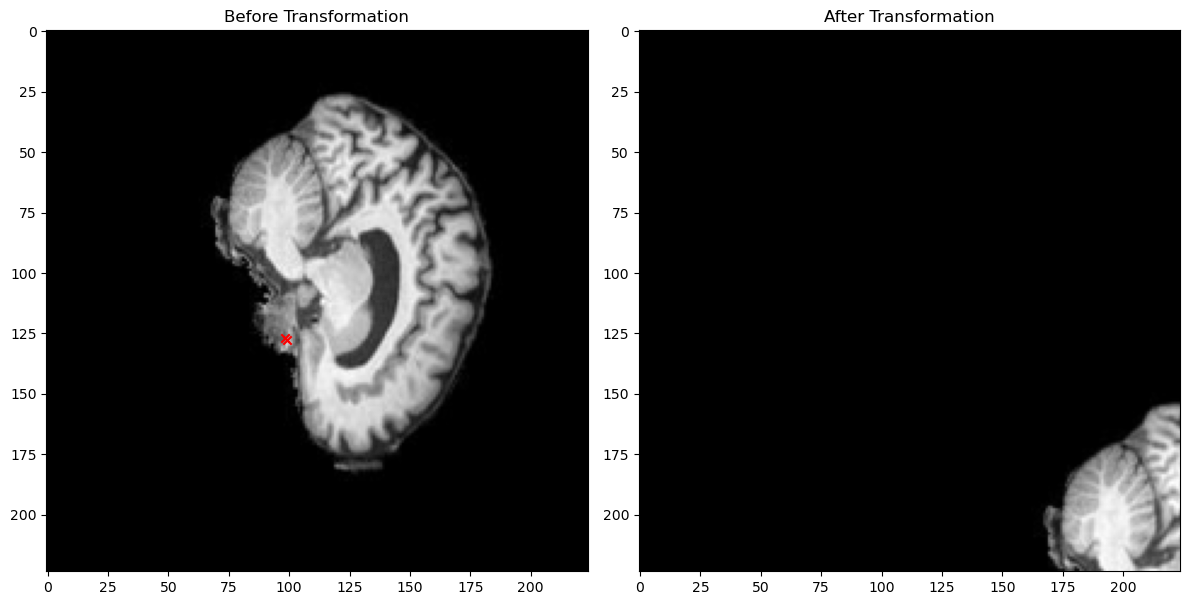

In [4]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Plot the first image BEFORE transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
image_to_plot = images[0].numpy().transpose((1, 2, 0))
plt.imshow(image_to_plot.squeeze(), cmap='gray')
plt.title("Before Transformation")

x_com, y_com = centre_of_mass(images[0])
plt.imshow(images[0].squeeze().numpy(), cmap='gray')
plt.scatter(x_com.item(), y_com.item(), c='red', marker='x')

# Apply the centre_transform
centered_image, x_trans, y_trans = centre_transform(images[0])

plt.scatter(x_com.item() + x_trans, y_com.item() + y_trans, c='red', marker='x')

plt.subplot(1, 2, 2)
image_to_plot = centered_image.numpy().transpose((1, 2, 0))
plt.imshow(image_to_plot.squeeze(), cmap='gray')
plt.title("After Transformation")

plt.tight_layout()
plt.show()